In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors

# Parameters from the paper
x_c = 2
x_c1 = 3.2
x_c2 = 4
a = 5
b = 1
L=500
dt=0.1


## Necessary function


In [18]:
# Equation 5,6
def normal_velocity(Dx, x_c=x_c):
    return np.tanh(Dx - x_c) + np.tanh(x_c)

def night_velocity(Dx, x_c=x_c, x_c1=x_c1, x_c2=x_c2, a=a, b=b):
    V = np.zeros_like(Dx)
    mask1 = Dx < x_c1
    mask2 = (Dx >= x_c1) & (Dx < x_c2)
    mask3 = Dx >= x_c2
    V[mask1] = np.tanh(Dx[mask1] - x_c) + np.tanh(x_c)
    V[mask2] = a - Dx[mask2]
    V[mask3] = b 
    return V

def normal_velocity_derivative(Dx, x_c=x_c):
    '''
    Derivative of normal optimal velocity function
    V(Δx) = tanh(Δx - x_c) + tanh(x_c)
    V'(Δx) = sech²(Δx - x_c) = 1 - tanh²(Δx - x_c)
    '''
    return 1 - np.tanh(Dx - x_c)**2

def night_velocity_derivative(Dx, x_c=x_c, x_c1=x_c1, x_c2=x_c2):
    '''
    Derivative of night traffic optimal velocity function
    For Dx < x_c1: V'(Δx) = sech²(Δx - x_c) = 1 - tanh²(Δx - x_c)
    For x_c1 < Dx < x_c2: For V(Δx) = a - Δx, the derivative is V'(Δx) = -1 (since 'a' is constant)
    For Dx > x_c2: V'(Δx) = 0
    V'(Δx) < κ/2 + λ to get model linear stability
    '''
    V_prime = np.zeros_like(Dx)

    mask1 = Dx < x_c1
    V_prime[mask1] = 1 - np.tanh(Dx[mask1] - x_c)**2

    mask2 = (Dx >= x_c1) & (Dx < x_c2)
    V_prime[mask2] = -1
    
    mask3 = Dx >= x_c2
    V_prime[mask3] = 0  
    return V_prime

def get_headways(positions,N, L=500):
    """Calculate headways with periodic boundary conditions"""
    headways = np.zeros(len(positions))
    for i in range(N):
        leader = (i - 1) % N
        delta_x = positions[leader] - positions[i]
        delta_x=delta_x%L # periodic
        headways[i] = delta_x
    return headways

def update_with_perturbation(x,v,N,kappa, lambda_param,use_night_driving,
                             perturbation_active,perturbation_counter,vehicle_stopped, perturbed_vehicles,n_dec,deceleration=1):
    """Update system with perturbation logic"""
    
    '''Calculate a following Eq.1'''
    headways = get_headways(x,N)
    accelerations = np.zeros(N)
    for i in range(N):
        prev_idx = (i - 1) % N     #-1=149=last
        headway = headways[i]
    # FVD model acceleration (Equation 1). Chỉ ban đêm mới có pertubation
        if use_night_driving:
            optimal_velocity = night_velocity(np.array([headway]))[0]
        else: 
            optimal_velocity = normal_velocity(np.array([headway]))[0]
        velocity_diff = v[prev_idx] - v[i]
        accelerations[i] = (kappa * (optimal_velocity - v[i]) + lambda_param * velocity_diff)
    
    '''Apply perturbation to specific vehicle, fix a and v'''
    if perturbation_active and perturbation_counter < n_dec:
        for pv in perturbed_vehicles:
            if not vehicle_stopped:
                accelerations[pv] = -deceleration
                # Check if vehicle will reach zero velocity
                new_velocity = (v[pv] + accelerations[pv] * dt)    # -1 mỗi đelta t
                
                if new_velocity <= 0:
                        v[pv] = 0
                        vehicle_stopped = True
            else:
                # Vehicle remains stopped for remaining time steps
                accelerations[pv] = 0
                v[pv] = 0
            
        perturbation_counter += 1
        if perturbation_counter >= n_dec:
            perturbation_active = False
    
    '''Update velocities Eq.3 (except for stopped vehicle during perturbation)'''
    for i in range(N):
        if not (perturbation_active and i in perturbed_vehicles and vehicle_stopped):
            v[i] += accelerations[i] * dt
            v[i] = max(0, v[i])
    
    '''Update positions Eq.4'''
    for i in range(N):
        x[i] += v[i] * dt + 0.5 * accelerations[i] * (dt**2)
        x[i] = x[i] % L  # Periodic boundary
    
    return x,v,perturbation_active, vehicle_stopped, perturbation_counter

def check_stability(x,N, kappa, lambda_param):
    """Check linear stability condition V'(Δx) < κ/2 + λ to get model linear stability """
    headways = get_headways(x,N)
    V_prime = night_velocity_derivative(headways)
    stability_threshold = kappa/2 + lambda_param
    unstable_mask = V_prime >= stability_threshold
    return {
            'headways': headways,
            'V_prime': V_prime,
            'stability_threshold': stability_threshold,
            'unstable_regions': unstable_mask,
            'is_stable': np.all(V_prime < stability_threshold)
        }

## Fig 1

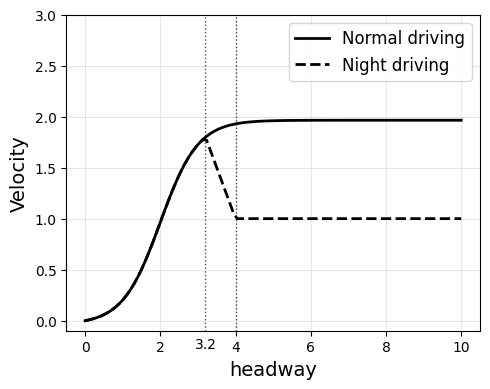

In [19]:
# Create headway range
headway = np.linspace(0, 10, 100)

V_normal = normal_velocity(headway, x_c)
V_night = night_velocity(headway, x_c, x_c1, x_c2, a, b)


plt.figure(figsize=(5,4))
plt.plot(headway, V_normal, 'k-', linewidth=2, label='Normal driving')
plt.plot(headway, V_night, 'k--', linewidth=2, label='Night driving')

plt.axvline(x=x_c1, color='black', linestyle=':', alpha=0.7, linewidth=1)
plt.axvline(x=x_c2, color='black', linestyle=':', alpha=0.7, linewidth=1)
plt.text(x_c1, -0.16, f'{x_c1}', ha='center', va='top', color='black', fontsize=10)

# Formatting
plt.xlabel('headway', fontsize=14)
plt.ylabel('Velocity', fontsize=14)
plt.ylim(top=3.0)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
# plt.title('Optimal Velocity Functions: Normal vs Night Driving', fontsize=14)
plt.tight_layout()
plt.show()

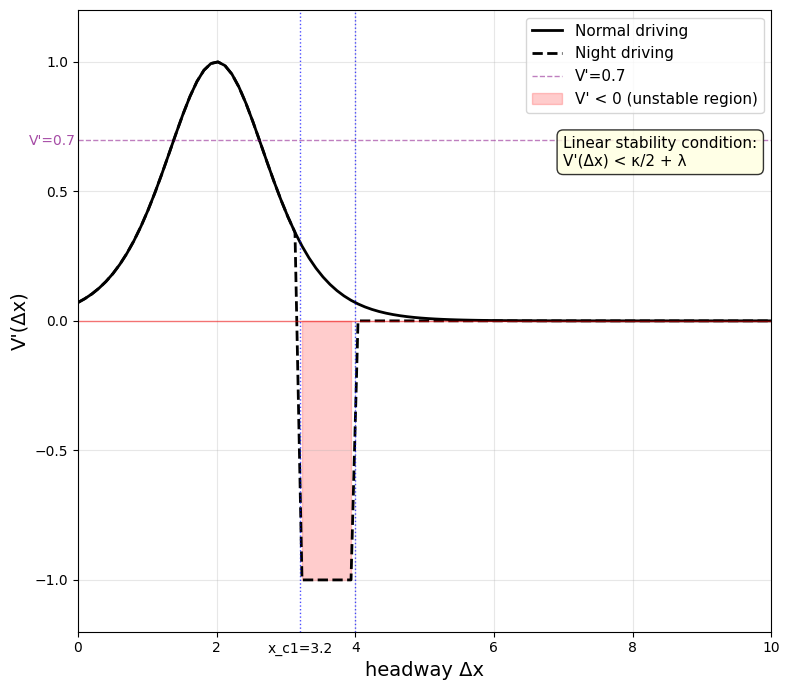

In [20]:
V_prime_normal = normal_velocity_derivative(headway)
V_prime_night = night_velocity_derivative(headway)

plt.figure(figsize=(8, 7))
plt.plot(headway, V_prime_normal, 'k-', linewidth=2, label="Normal driving")
plt.plot(headway, V_prime_night, 'k--', linewidth=2, label="Night driving")

plt.axvline(x=x_c1, color='blue', linestyle=':', alpha=0.7, linewidth=1)
plt.axvline(x=x_c2, color='blue', linestyle=':', alpha=0.7, linewidth=1)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)
plt.axhline(y=0.7,color='purple', linestyle='--', alpha=0.5, linewidth=1, label="V'=0.7")
plt.text(x_c1,-1.24, f'x_c1={x_c1}', ha='center', va='top', color='black', fontsize=10)
plt.text(x=-0.7, y=0.7-0.02,   # x là vị trí ngang (tùy chỉnh theo trục x), y là hơi lệch lên so với y=0.7
         s="V'=0.7",           
        color='purple',
        fontsize=10,
        alpha=0.7
)

# negative region for night driving
plt.fill_between(headway, V_prime_night, 0, where=(V_prime_night < 0), 
                 alpha=0.2, color='red', label='V\' < 0 (unstable region)')

# Add stability condition annotation
plt.text(7, 0.6, 'Linear stability condition:\nV\'(Δx) < κ/2 + λ', 
         fontsize=11, bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.8))

# Formatting
plt.xlabel('headway Δx', fontsize=14)
plt.ylabel("V'(Δx)", fontsize=14)
plt.xlim(0, 10)
plt.ylim(-1.2, 1.2)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
# plt.title("Derivative of Optimal Velocity Functions", fontsize=14)

plt.tight_layout()
plt.show()


INITIALIZATION ANALYSIS
N = 150, κ = 1.0, λ = 0.5
Initial spacing ≈ 3.33 (in range 3.2-4)


Creating space-time plot...
Creating trajectory plot...


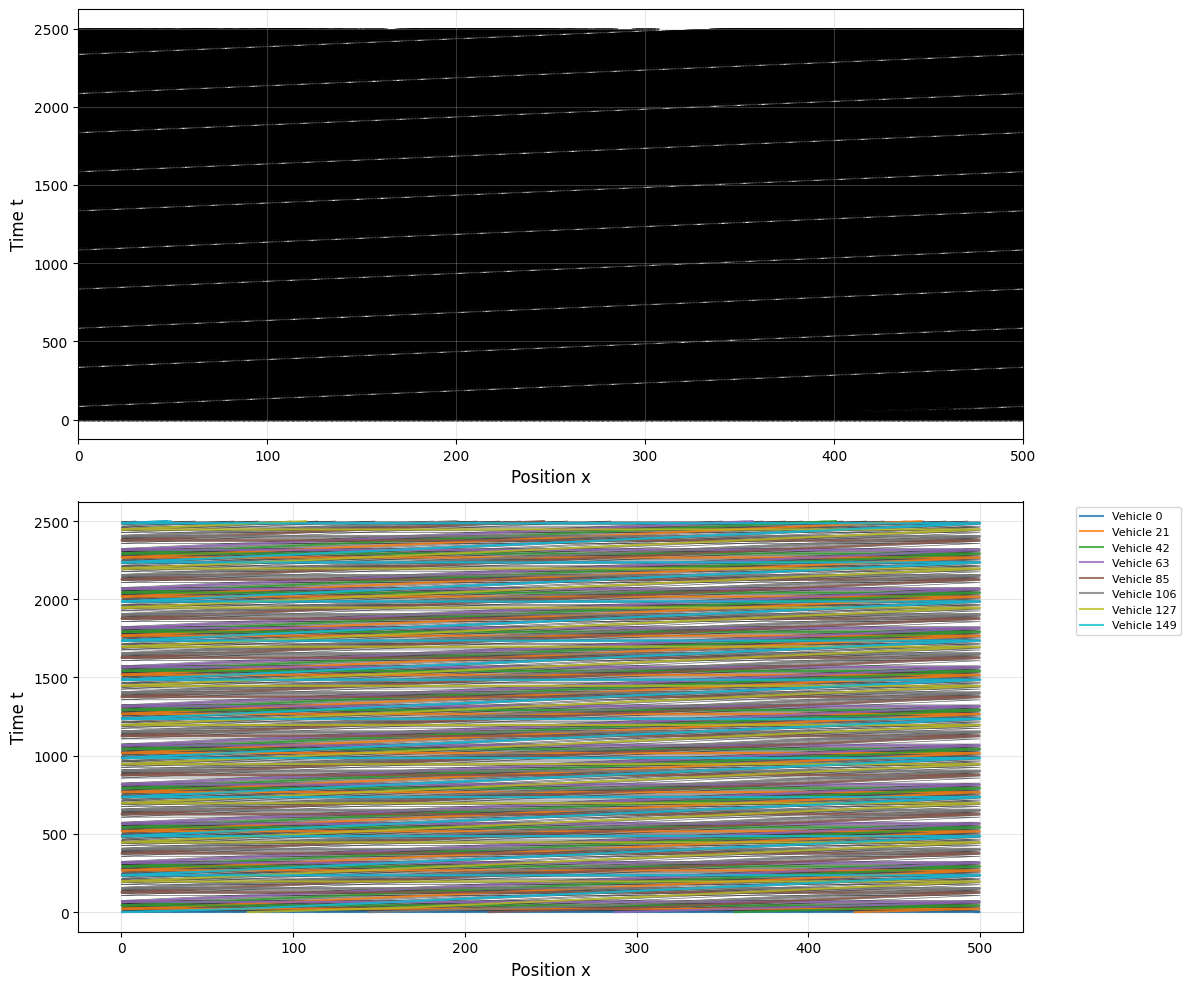


Average velocity: 1.000
Velocity std deviation: 0.000

Number of clusters (headways > 4): 37
Leader vehicles have headway > x_c2 = 4 move with velocity ≈ 1
Cluster sizes: [2, 2, 2, 2, 6, 4, 8, 11, 9, 9, 13, 4, 2, 2, 2, 2, 6, 4, 8, 8, 3, 2, 2, 2, 2, 2, 6, 4, 2, 2, 2, 5, 2, 2, 2, 2, 2]

Creating detailed clustering visualization...


/tmp/ipykernel_760151/1924017829.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


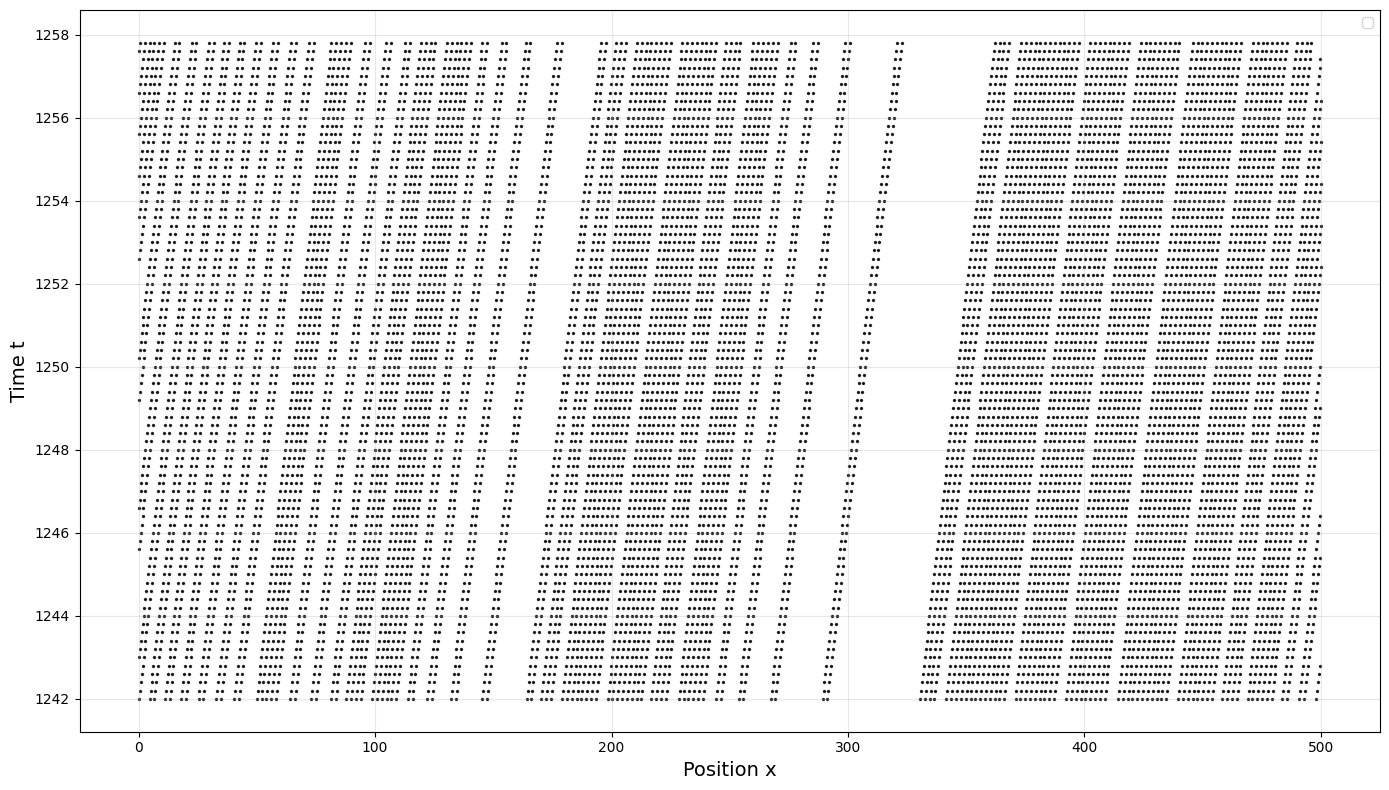

In [23]:
def simulate_clustering(x_min, x_max,N=150, kappa_local=1.0, lambda_param_local=0.5,apply_perturbation=False, L=L, dt=dt, T_max=2500, n_dec=0, deceleration=1.0):
    '''Change lambda, N,apply_perturb for Fig 3,5,7, '''
    '''Initialize vehicles in the density range x_min < Dx < x_max => unstable, clustering occurs'''
    print("INITIALIZATION ANALYSIS")
    initial_spacing = L / N
    if x_min > initial_spacing or initial_spacing >x_max:
        print("stable range")

    x = np.array([i * initial_spacing for i in range(N)])[::-1]
    initial_optimal_v = night_velocity(np.array([initial_spacing]))[0] 
    v = np.ones(N) * initial_optimal_v

    n_steps = int(T_max / dt)
    n_save = 2  # save steps for plotting

    time_points = []
    position_data = []


    if apply_perturbation:
        perturbation_active = True
        perturbation_counter = 0
        vehicle_stopped = False
        perturbation_vehicles = list(range(0, N, max(1, N//15)))[:1]
    else: 
        perturbation_active = False
        perturbation_counter = 0
        vehicle_stopped = False
        perturbation_vehicles = None
    print(f"N = {N}, κ = {kappa_local}, λ = {lambda_param_local}")
    print(f"Initial spacing ≈ {initial_spacing:.2f} (in range {x_c1}-{x_c2})")
    print('\n')

    for step in range(n_steps):
        t = step * dt
        x, v, perturbation_active, vehicle_stopped, perturbation_counter = update_with_perturbation(
            x=x, v=v, N=N, kappa=kappa_local, lambda_param=lambda_param_local,
            use_night_driving=True,
            perturbation_active=perturbation_active,
            perturbation_counter=perturbation_counter,
            vehicle_stopped=vehicle_stopped,
            perturbed_vehicles=perturbation_vehicles,
            n_dec=n_dec
        )
    
        # Calc headways (with periodic boundary conditions)
        headways= get_headways(x, N)

        V_opt = night_velocity(headways)
    
        acceleration = np.zeros(N)
        for i in range(N):
            prev_i = (i - 1) % N
            acceleration[i] = kappa_local * (V_opt[i] - v[i]) + lambda_param_local * (v[prev_i] - v[i])  #Eq. 1
            if step < n_dec:
                acceleration[perturbation_vehicles] = -deceleration
    
        # Update velocities and positions like Eq.3 and Eq.4
        v = v + acceleration * dt
        v = np.maximum(v, 0) 
        x = x + v * dt + 0.5 * acceleration * dt**2
        x = x % L

        if step % n_save == 0:
            time_points.append(t)
            position_data.append(x.copy())

    time_points = np.array(time_points)
    position_data = np.array(position_data)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    '''Top plot: Space-time diagram like Figure 3'''
    print("Creating space-time plot...")
    for t_idx, t in enumerate(time_points):
        positions = position_data[t_idx, :]
        # small dots to represent vehicles -> easier see
        ax1.scatter(positions, [t] * len(positions), c='black', s=1, alpha=0.3)

    ax1.set_xlabel('Position x', fontsize=12)
    ax1.set_ylabel('Time t', fontsize=12)
    # ax1.set_title(f'Space-Time Diagram - Night Driving Clustering (N={N}, κ={kappa}, λ={lambda_param})', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, L)

    '''Bottom plot: Alternative visualization showing vehicle trajectories'''
    print("Creating trajectory plot...")
    # few vehicles to avoid clutter
    step_size = max(1, N // 30)
    for i in range(0, N, step_size):
        vehicle_positions = position_data[:, i]
        ax2.plot(vehicle_positions, time_points, 'k-', linewidth=0.5, alpha=0.6)

    # Highlight specific vehicles
    highlight_vehicles = np.linspace(0, N-1, 8, dtype=int)
    colors = plt.cm.tab10(np.linspace(0, 1, len(highlight_vehicles)))

    for i, vehicle in enumerate(highlight_vehicles):
        vehicle_positions = position_data[:, vehicle]
        ax2.plot(vehicle_positions, time_points, color=colors[i], linewidth=1.5, 
                alpha=0.8, label=f'Vehicle {vehicle}')
        
    ax2.set_xlabel('Position x', fontsize=12)
    ax2.set_ylabel('Time t', fontsize=12)
    # ax2.set_title('Vehicle Trajectories Showing Cluster Formation', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()


    # Analyze final state
    final_positions = position_data[-1, :]
    final_velocities = v

    # Calculate final headways
    final_headways = np.zeros(N)
    for i in range(N):
        next_i = (i - 1) % N
        dx = final_positions[next_i] - final_positions[i]
        if dx < 0:
            dx += L
        final_headways[i] = dx


    print(f"\nAverage velocity: {np.mean(final_velocities):.3f}")
    print(f"Velocity std deviation: {np.std(final_velocities):.3f}")

    # Identify clusters (vehicles with large headways are cluster leaders)
    large_headways = final_headways > x_c2
    cluster_leaders = np.where(large_headways)[0]
    n_clusters = len(cluster_leaders)

    print(f"\nNumber of clusters (headways > {x_c2}): {n_clusters}")

    if n_clusters > 0:
        print(f"Leader vehicles have headway > x_c2 = {x_c2} move with velocity ≈ {b}")
        
        # Calculate cluster sizes
        if n_clusters > 1:
            cluster_sizes = []
            sorted_leaders = np.sort(cluster_leaders)
            for i in range(n_clusters):
                next_leader = sorted_leaders[(i + 1) % n_clusters]
                if next_leader > sorted_leaders[i]:
                    size = next_leader - sorted_leaders[i]
                else:
                    size = (N - sorted_leaders[i]) + next_leader
                cluster_sizes.append(size)
            print(f"Cluster sizes: {cluster_sizes}")
    else:
        print("No clear clustering observed - try different parameters")

    '''Create a zoomed version focusing on clustering pattern (Figure 3 style plot)'''
    print("\nCreating detailed clustering visualization...")

    # Find time range where clustering is most visible
    mid_time_idx = len(time_points) // 2
    zoom_start = max(0, mid_time_idx - 40)
    zoom_end = min(len(time_points), mid_time_idx + 40)

    plt.figure(figsize=(14, 8))

    for t_idx in range(zoom_start, zoom_end):
        t = time_points[t_idx]
        positions = position_data[t_idx, :]
        # Plot vehicles as points
        plt.scatter(positions, [t] * len(positions), c='black', s=2, alpha=0.8)
    plt.xlabel('Position x', fontsize=14)
    plt.ylabel('Time t', fontsize=14)
    # plt.title('Detailed View of Clustering Pattern (Night Driving)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [24]:
simulate_clustering(x_c1, x_c2,N=150, kappa_local=1.0, lambda_param_local=0.5, apply_perturbation=False,T_max=2500,n_dec=0)

INITIALIZATION ANALYSIS
N = 150, κ = 1.0, λ = 0.5
Initial spacing ≈ 3.33 (in range 3.2-4)


Creating space-time plot...


## Fig 4

Creating Figure 6 - Fundamental Diagram
1.0 0.2
Simulating traffic for different densities...
Progress: 1/33 (N=10)
Progress: 2/33 (N=25)
Progress: 3/33 (N=40)
Progress: 4/33 (N=55)
Progress: 5/33 (N=70)
Progress: 6/33 (N=85)
Progress: 7/33 (N=100)
Progress: 8/33 (N=115)
Progress: 9/33 (N=130)
Progress: 10/33 (N=145)
Progress: 11/33 (N=160)
Progress: 12/33 (N=175)
Progress: 13/33 (N=190)
Progress: 14/33 (N=205)
Progress: 15/33 (N=220)
Progress: 16/33 (N=235)
Progress: 17/33 (N=250)
Progress: 18/33 (N=265)
Progress: 19/33 (N=280)
Progress: 20/33 (N=295)
Progress: 21/33 (N=310)
Progress: 22/33 (N=325)
Progress: 23/33 (N=340)
Progress: 24/33 (N=355)
Progress: 25/33 (N=370)
Progress: 26/33 (N=385)
Progress: 27/33 (N=400)
Progress: 28/33 (N=415)
Progress: 29/33 (N=430)
Progress: 30/33 (N=445)
Progress: 31/33 (N=460)
Progress: 32/33 (N=475)
Progress: 33/33 (N=490)


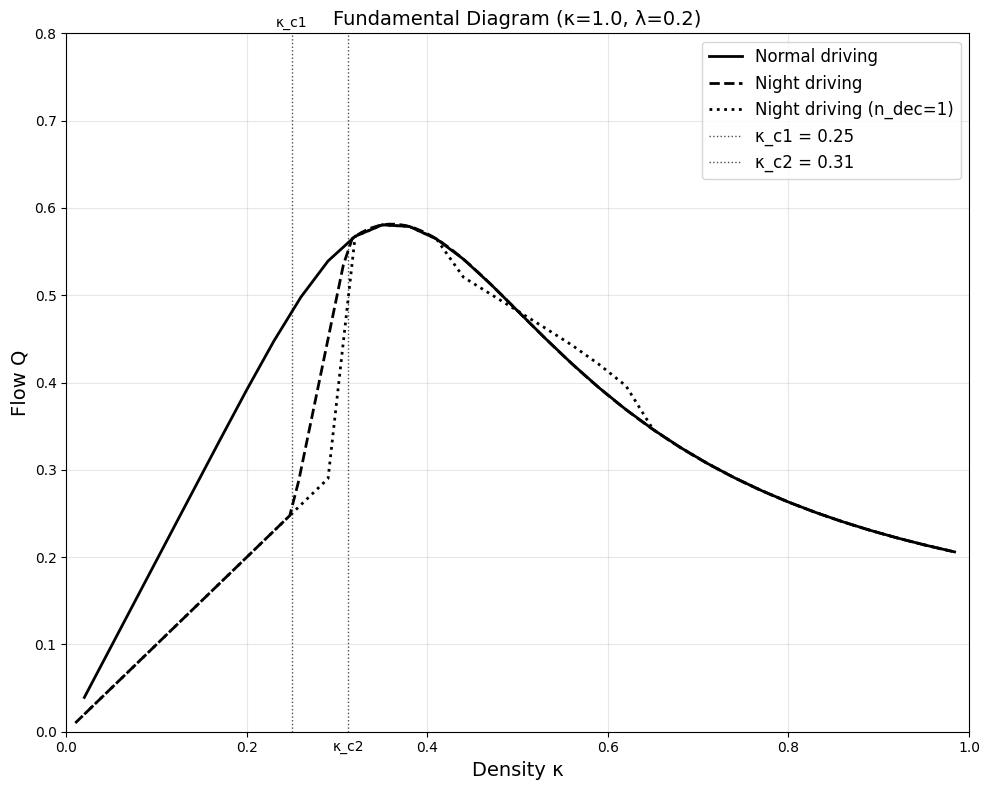


Analysis Results:
Critical densities: κ_c1 = 0.25000, κ_c2 = 0.31250


In [16]:

# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters from the paper
# x_c = 2
# x_c1 = 3.2
# x_c2 = 4
# a = 5
# b = 1
# L=500
# dt=0.1


# # Equation 5,6
# def normal_velocity(Dx, x_c=x_c):
#     return np.tanh(Dx - x_c) + np.tanh(x_c)

# def night_velocity(Dx, x_c=x_c, x_c1=x_c1, x_c2=x_c2, a=a, b=b):
#     V = np.zeros_like(Dx)
#     mask1 = Dx < x_c1
#     mask2 = (Dx >= x_c1) & (Dx < x_c2)
#     mask3 = Dx >= x_c2
#     V[mask1] = np.tanh(Dx[mask1] - x_c) + np.tanh(x_c)
#     V[mask2] = a - Dx[mask2]
#     V[mask3] = b 
#     return V

# def normal_velocity_derivative(Dx, x_c=x_c):
#     '''
#     Derivative of normal optimal velocity function
#     V(Δx) = tanh(Δx - x_c) + tanh(x_c)
#     V'(Δx) = sech²(Δx - x_c) = 1 - tanh²(Δx - x_c)
#     '''
#     return 1 - np.tanh(Dx - x_c)**2

# def night_velocity_derivative(Dx, x_c=x_c, x_c1=x_c1, x_c2=x_c2):
#     '''
#     Derivative of night traffic optimal velocity function
#     For Dx < x_c1: V'(Δx) = sech²(Δx - x_c) = 1 - tanh²(Δx - x_c)
#     For x_c1 < Dx < x_c2: For V(Δx) = a - Δx, the derivative is V'(Δx) = -1 (since 'a' is constant)
#     For Dx > x_c2: V'(Δx) = 0
#     V'(Δx) < κ/2 + λ to get model linear stability
#     '''
#     V_prime = np.zeros_like(Dx)

#     mask1 = Dx < x_c1
#     V_prime[mask1] = 1 - np.tanh(Dx[mask1] - x_c)**2

#     mask2 = (Dx >= x_c1) & (Dx < x_c2)
#     V_prime[mask2] = -1
    
#     mask3 = Dx >= x_c2
#     V_prime[mask3] = 0  
#     return V_prime

# def get_headways(positions,N, L=500):
#     """Calculate headways with periodic boundary conditions"""
#     headways = np.zeros(len(positions))
#     for i in range(N):
#         leader = (i - 1) % N
#         delta_x = positions[leader] - positions[i]
#         delta_x=delta_x%L # periodic
#         headways[i] = delta_x
#     return headways

# def update_with_perturbation(x,v,N,kappa, lambda_param,use_night_driving,
#                              perturbation_active,perturbation_counter,vehicle_stopped, perturbed_vehicles,n_dec,deceleration=1):
#     """Update system with perturbation logic"""
    
#     '''Calculate a following Eq.1'''
#     headways = get_headways(x,N)
#     accelerations = np.zeros(N)
#     for i in range(N):
#         prev_idx = (i - 1) % N     #-1=149=last
#         headway = headways[i]
#     # FVD model acceleration (Equation 1). Chỉ ban đêm mới có pertubation
#         if use_night_driving:
#             optimal_velocity = night_velocity(np.array([headway]))[0]
#         else: 
#             optimal_velocity = normal_velocity(np.array([headway]))[0]
#         velocity_diff = v[prev_idx] - v[i]
#         accelerations[i] = (kappa * (optimal_velocity - v[i]) + lambda_param * velocity_diff)
    
#     '''Apply perturbation to specific vehicle, fix a and v'''
#     if perturbation_active and perturbation_counter < n_dec:
#         for pv in perturbed_vehicles:
#             if not vehicle_stopped:
#                 accelerations[pv] = -deceleration
#                 # Check if vehicle will reach zero velocity
#                 new_velocity = (v[pv] + accelerations[pv] * dt)    # -1 mỗi đelta t
                
#                 if new_velocity <= 0:
#                         v[pv] = 0
#                         vehicle_stopped = True
#             else:
#                 # Vehicle remains stopped for remaining time steps
#                 accelerations[pv] = 0
#                 v[pv] = 0
            
#         perturbation_counter += 1
#         if perturbation_counter >= n_dec:
#             perturbation_active = False
    
#     '''Update velocities Eq.3 (except for stopped vehicle during perturbation)'''
#     for i in range(N):
#         if not (perturbation_active and i in perturbed_vehicles and vehicle_stopped):
#             v[i] += accelerations[i] * dt
#             v[i] = max(0, v[i])
    
#     '''Update positions Eq.4'''
#     for i in range(N):
#         x[i] += v[i] * dt + 0.5 * accelerations[i] * (dt**2)
#         x[i] = x[i] % L  # Periodic boundary
    
#     return x,v,perturbation_active, vehicle_stopped, perturbation_counter

# def check_stability(x,N, kappa, lambda_param):
#     """Check linear stability condition V'(Δx) < κ/2 + λ to get model linear stability """
#     headways = get_headways(x,N)
#     V_prime = night_velocity_derivative(headways)
#     stability_threshold = kappa/2 + lambda_param
#     unstable_mask = V_prime >= stability_threshold
#     return {
#             'headways': headways,
#             'V_prime': V_prime,
#             'stability_threshold': stability_threshold,
#             'unstable_regions': unstable_mask,
#             'is_stable': np.all(V_prime < stability_threshold)
#         }

def simulate_traffic(N,L,k,lamb, use_night_driving=True, apply_perturbation=False, T_max=250,n_dec=1):
    """
    Simulate traffic flow using FVD model
    Returns: density, flow
    """
    ''' 
    Initialize positions uniformly
    Theo paper, intial status là homogenous traffic, và chú ý xe vị trí càng to thì index càng bé( xe n là head của xe n+1))
    '''
    initial_spacing = L / N
    x = np.array([i * initial_spacing for i in range(N)])[::-1]
    
    # Initialize velocities
    if use_night_driving:
        initial_v = night_velocity(np.array([initial_spacing]))[0]
    else:
        initial_v = normal_velocity(np.array([initial_spacing]))[0]
    
    v = np.ones(N) * max(0.1, initial_v)  # Avoid zero initial velocity
    
    n_steps = int(T_max / dt)
    if apply_perturbation:
        perturbation_active = True
        perturbed_vehicles = list(range(0, N, max(1, N//15)))[:1]
        perturbation_counter = 0
        vehicle_stopped = False
    else:
        '''Normal without perturbation'''
        perturbation_active = False
        perturbed_vehicles = None
        perturbation_counter = 0
        vehicle_stopped = False
###################################################################################
    # Run simulation
    for step in range(n_steps):
        x,v,perturbation_active,vehicle_stopped,perturbation_counter = update_with_perturbation(x=x,v=v,N=N,kappa=k, lambda_param=lamb, use_night_driving=use_night_driving,
                                                                                                perturbation_active=perturbation_active,perturbation_counter=perturbation_counter,
                                                                                                vehicle_stopped=vehicle_stopped, perturbed_vehicles=perturbed_vehicles,n_dec=n_dec)
    # Calculate final density and flow
    density = N / L
    final_flow = density * np.mean(v)
    
    return density, final_flow
###################################################################################
def create_fundamental_diagram(N_max,L,k,lamb,n_dec=1):
    """Create Figure 4 - Fundamental diagram with three curves"""
    
    # Range of vehicle numbers to test different densities
    N_values = np.arange(10, N_max, 15)  # From low to high density
    
    densities_normal = []
    flows_normal = []
    densities_night = []
    flows_night = []
    densities_night_pert = []
    flows_night_pert = []
    
    print("Simulating traffic for different densities...")
    
    for i, N in enumerate(N_values):
        print(f"Progress: {i+1}/{len(N_values)} (N={N})")
        
        # Normal driving
        density_norm, flow_norm = simulate_traffic(N,L,k,lamb, use_night_driving=False, apply_perturbation=False)
        densities_normal.append(density_norm)
        flows_normal.append(flow_norm)
        
        
        # Night driving with small perturbations
        density_night_p, flow_night_p = simulate_traffic(N,L,k,lamb, use_night_driving=True, apply_perturbation=True,T_max=2500)
        densities_night_pert.append(density_night_p)
        flows_night_pert.append(flow_night_p)
    

    # Convert to numpy arrays
    densities_normal = np.array(densities_normal)
    flows_normal = np.array(flows_normal)

    densities_night_pert = np.array(densities_night_pert)
    flows_night_pert = np.array(flows_night_pert)
    
    # Compute THEORETICAL NIGHT (dashed line) - NOT simulated!
    densities_night_theory = np.linspace(0.01, 0.99, 100)
    headways_theory = 1 / densities_night_theory
    flows_night_theory = densities_night_theory * night_velocity(headways_theory)
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot the three curves
    plt.plot(densities_normal, flows_normal, 'k-', linewidth=2, label='Normal driving', markersize=4)
    plt.plot(densities_night_theory, flows_night_theory, 'k--', linewidth=2, label='Night driving', markersize=4)
    plt.plot(densities_night_pert, flows_night_pert, 'k:', linewidth=2, label='Night driving (n_dec=1)', markersize=4)
    
    # Calculate key density points for night driving
    rho_c1 = 1.0 / x_c2  # κ_c1 in the paper
    rho_c2 = 1.0 / x_c1  # κ_c2 in the paper
    plt.axvline(rho_c1, color='black', linestyle=':', alpha=0.7, linewidth=1, label=f'κ_c1 = {rho_c1:.2f}')
    plt.axvline(rho_c2, color='black', linestyle=':', alpha=0.7, linewidth=1, label=f'κ_c2 = {rho_c2:.2f}')
    plt.text(rho_c2, -0.01, f'κ_c2', ha='center', va='top', color='black', fontsize=10)
    plt.text(rho_c1, 0.82, f'κ_c1', ha='center', va='top', color='black', fontsize=10)

    # Formatting
    plt.xlabel('Density κ', fontsize=14)
    plt.ylabel('Flow Q', fontsize=14)
    plt.title(f'Fundamental Diagram (κ={kappa}, λ={lambda_param})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    plt.xlim(0,1)
    plt.ylim(0, 0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print some analysis
    print("\nAnalysis Results:")
    print(f"Critical densities: κ_c1 = {rho_c1:.5f}, κ_c2 = {rho_c2:.5f}")
    
    return (densities_normal, flows_normal, densities_night, flows_night, 
            densities_night_pert, flows_night_pert)

if __name__ == "__main__":
    kappa = 1.0
    lambda_param = 0.2
    print("Creating Figure 6 - Fundamental Diagram")

    run_full_simulation = True 
    
    if run_full_simulation:
        print(kappa, lambda_param)
        results = create_fundamental_diagram(501,L,k=kappa,lamb=lambda_param, n_dec=1)

## Fig 5


INITIALIZATION ANALYSIS
Fig 5
N = 250, κ = 1.0, λ = 0.2
Initial spacing ≈ 2.00 (in range 2.5-1.5384615384615383)


Creating space-time plot...
Creating trajectory plot...


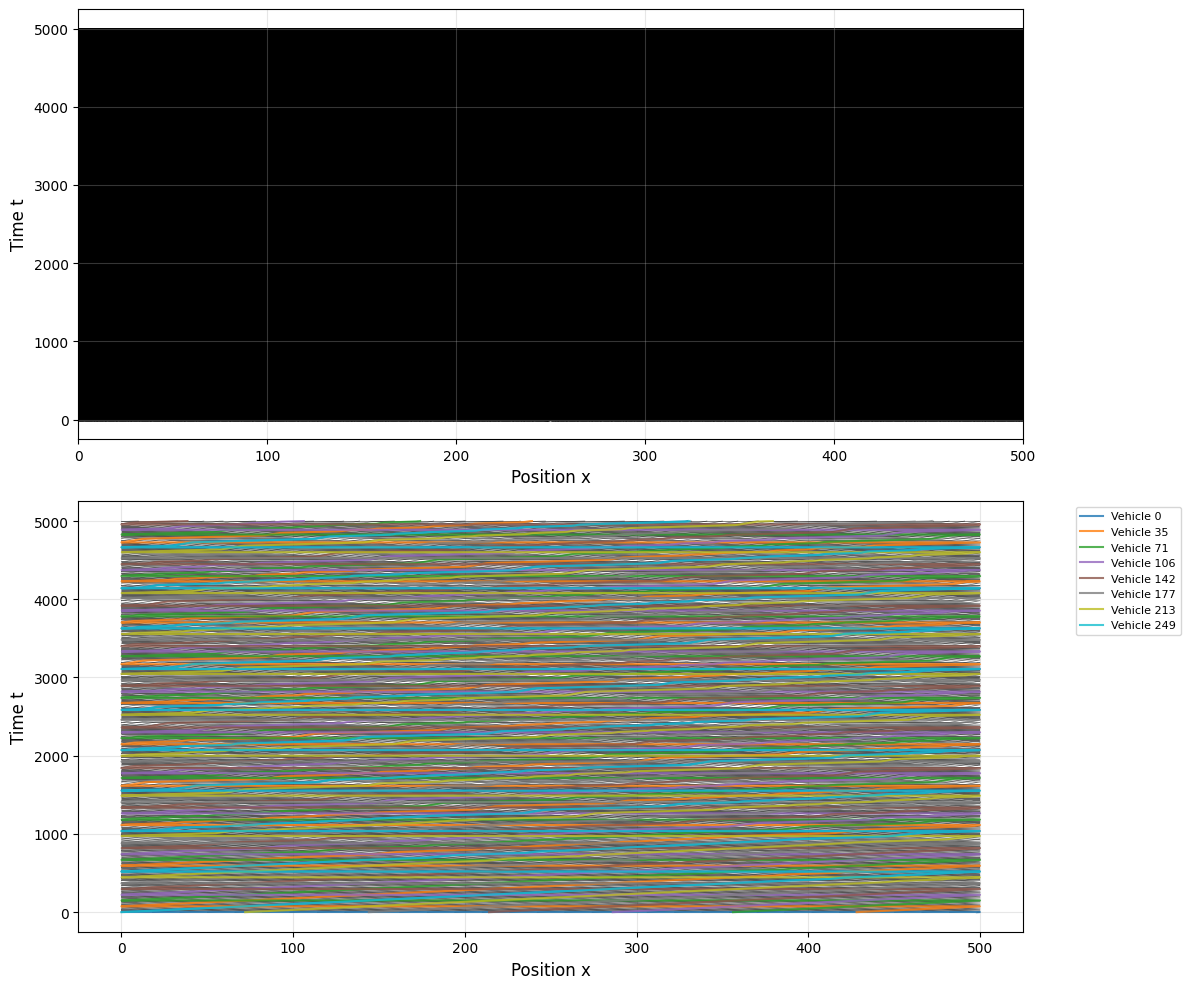


Average velocity: 0.964
Velocity std deviation: 0.637

Number of clusters (headways > 4): 0
No clear clustering observed - try different parameters

Creating detailed clustering visualization...


/tmp/ipykernel_760151/52453750.py:176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


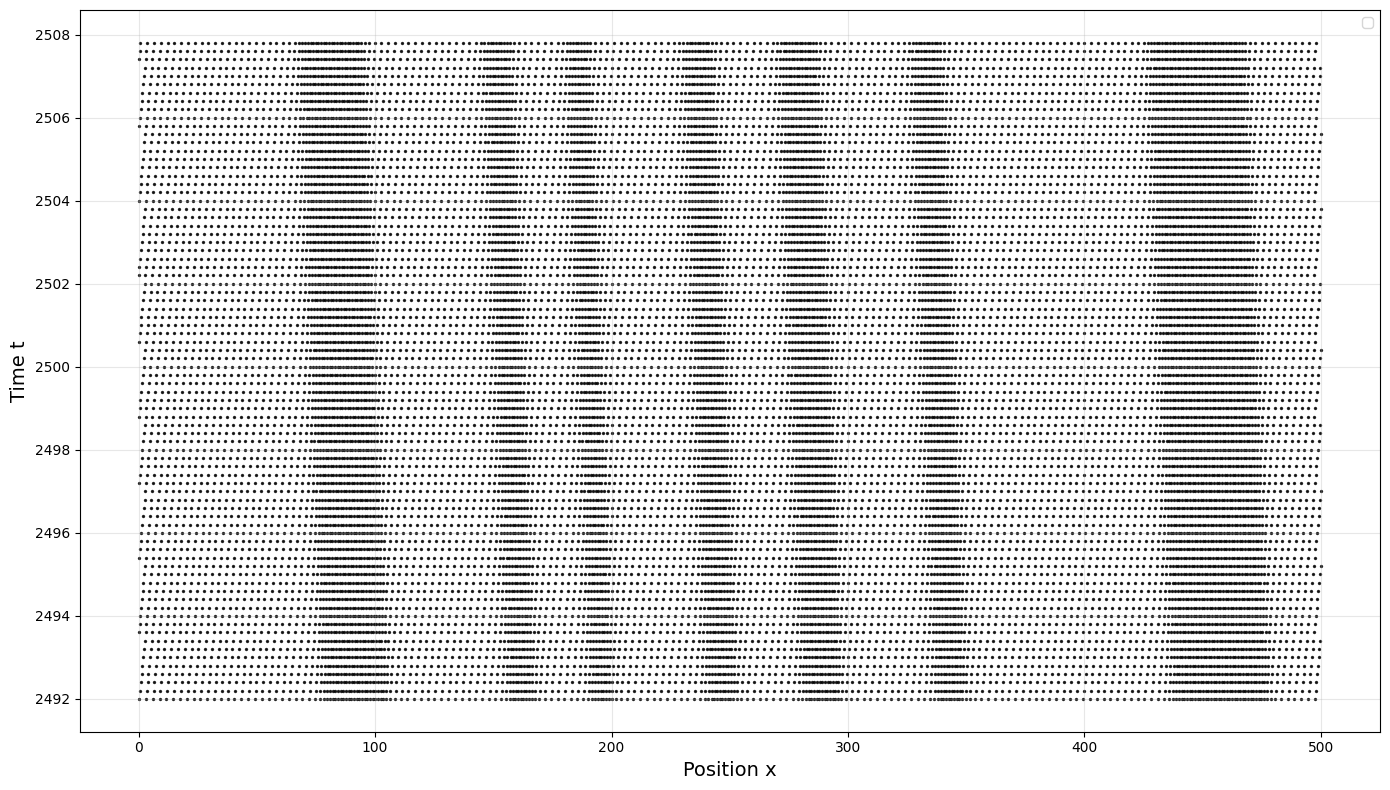

In [3]:
N = 250  # number of vehicles
kappa = 1.0  
lambda_param = 0.2
x_c4=1/0.65
x_c3 =1/0.4
simulate_clustering(x_c4, x_c3,N=N, kappa_local=kappa, lambda_param_local=lambda_param, apply_perturbation=True, T_max=2500, n_dec=1)

## Fig 6

## Fig 7


Testing TRUE UPDATE FUNCTION for night + perturbation
Running Code 2 style clustering simulation with plots...
INITIALIZATION ANALYSIS
Fig 7
N = 230, κ = 1.0, λ = 0.1
Initial spacing ≈ 2.17 (in range 2.0408163265306123-2.564102564102564)


Creating space-time plot...
Creating trajectory plot...


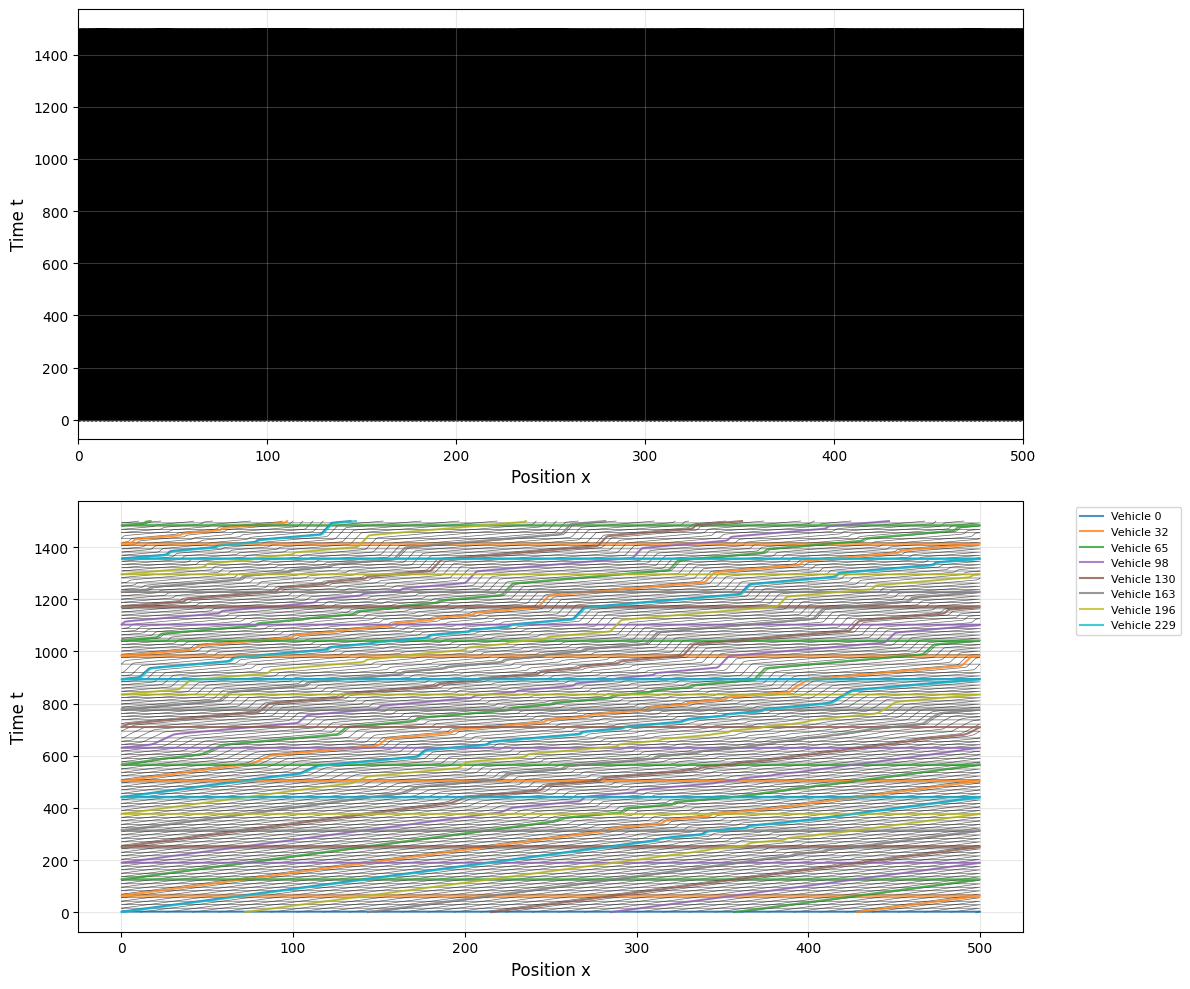


Average velocity: 1.087
Velocity std deviation: 0.748

Number of clusters (headways > 4): 0
No clear clustering observed - try different parameters

Creating detailed clustering visualization...


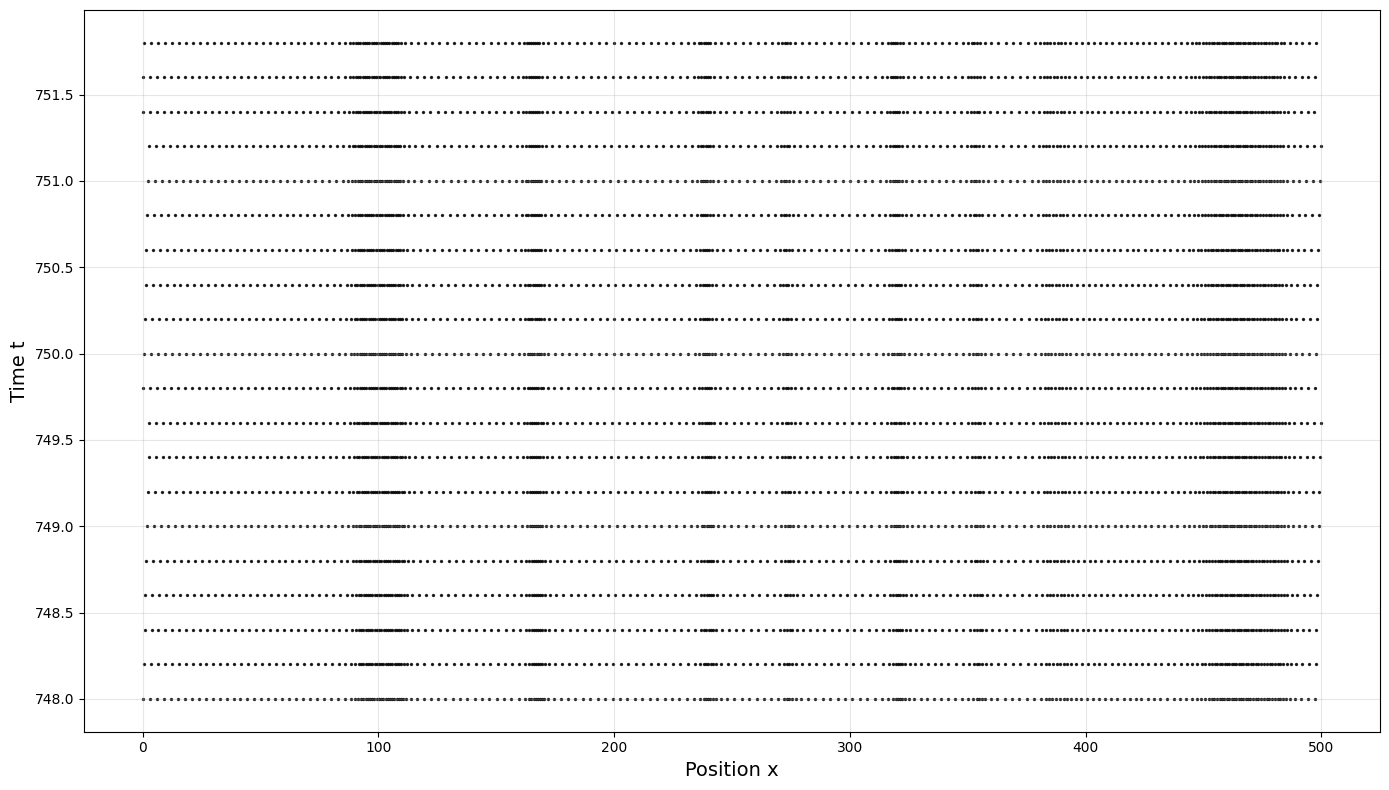

Simulation completed. Final average velocity: 1.087

Testing with fundamental diagram...
Density: 0.200, Flow: 0.200
